In [1]:
# Cell 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
import warnings

# Suppress warnings to keep output clean
# This includes convergence warnings from XGBoost and future warnings from pandas
warnings.filterwarnings('ignore')

# Enhanced plotting style
sns.set_theme()
sns.set_palette("husl")

In [2]:
# Cell 2: Load and Check Data
def load_and_check_data(file_path):
    """
    Load and perform initial data checks.

    Args:
        file_path: Path to data file
    Returns:
        pd.DataFrame: Loaded dataframe

    Example:
        >>> df = load_and_check_data("bank_data.csv")
        Dataset Shape: (45211, 17)
        No missing values found
    """
    print("Loading data...")
    df = pd.read_csv(file_path)

    print("=== Basic Dataset Information ===")
    print(f"Dataset Shape: {df.shape}")
    print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    print("\nFirst few rows:")
    print(df.head())

    print("\n=== Missing Values Check ===")
    missing = df.isnull().sum()
    print("Missing values found:" if missing.sum() > 0 else "No missing values")

    print("\n=== Data Types ===")
    print(df.dtypes)

    print("\nTarget Distribution:")
    print(df['y'].value_counts(normalize=True).round(3) * 100, "%")

    return df

In [3]:
# Cell 3: Detailed Balance Analysis
def analyze_balance_distribution(df):
    """
    Analyze balance distribution and create balance groups.

    Args:
        df: DataFrame with 'balance' column
    Returns:
        pd.Series: Balance group categories

    Example:
        >>> balance_groups = analyze_balance_distribution(df)
        Creating balance distribution plots...
        Balance groups created: negative, very_low, low, medium, high
    """
    print("\n=== Balance Distribution Analysis ===")

    # Create distribution plots
    print("Creating distribution plots...")
    plt.figure(figsize=(15, 5))

    # Plot 1: Full distribution
    plt.subplot(1, 2, 1)
    sns.histplot(df['balance'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Original Balance Distribution', fontsize=12, pad=15)
    plt.xlabel('Balance (€)', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.grid(True, alpha=0.3)

    # Plot 2: Focused on typical balances
    plt.subplot(1, 2, 2)
    sns.histplot(df[df['balance'] <= 15000]['balance'],
               bins=50, color='darkblue', edgecolor='black', alpha=0.7)
    plt.title('Balance Distribution (≤ 15000)', fontsize=12, pad=15)
    plt.xlabel('Balance (€)', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Calculate statistics
    print("\nCalculating balance statistics...")
    print("\nBalance Statistics:")
    print(df['balance'].describe())
    print(f"Skewness: {df['balance'].skew():.2f}")

    # Create balance groups
    print("\nCreating balance categories...")
    balance_groups = pd.cut(
        df['balance'],
        bins=[-float('inf'), 0, 1000, 5000, 15000, float('inf')],  # Balance category boundaries
        labels=['negative', 'very_low', 'low', 'medium', 'high']    # Category names
    )

    # Analyze groups
    print("\nAnalyzing balance groups...")
    group_stats = df.groupby(balance_groups).agg({
        'balance': ['count', 'mean', 'std'],
        'y': lambda x: (x == 'yes').mean() * 100  # Success rate as percentage
    }).round(2)
    print(group_stats)

    return balance_groups

In [4]:
# Cell 4: Univariate Analysis
def perform_univariate_analysis(df):
    """
    Perform univariate analysis of numeric and categorical features.

    Args:
        df: Input DataFrame

    Example:
        >>> perform_univariate_analysis(df)
        Analyzing numeric features...
        Age statistics: mean=41.2, std=10.4
    """
    # 1. Numeric Features Analysis
    numeric_cols = ['age', 'duration', 'campaign']
    colors = sns.color_palette("husl", len(numeric_cols))

    print("=== Numeric Features Analysis ===")
    for i, col in enumerate(numeric_cols):
        print(f"\nAnalyzing {col}...")
        print(df[col].describe())
        print(f"Skewness: {df[col].skew():.2f}")

        plt.figure(figsize=(12, 4))

        # Distribution plot
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=30, color=colors[i], edgecolor='black', alpha=0.7)
        plt.title(f'Distribution of {col.title()}', fontsize=12, pad=15)
        plt.grid(True, alpha=0.3)

        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col], color=colors[i])
        plt.title(f'Boxplot of {col.title()}', fontsize=12, pad=15)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # 2. Categorical Features Analysis
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                       'loan', 'contact', 'month']

    print("\n=== Categorical Features Analysis ===")
    for col in categorical_cols:
        print(f"\nAnalyzing {col}...")
        value_counts = df[col].value_counts(normalize=True).round(3)
        print(value_counts)

        plt.figure(figsize=(10, 5))
        ax = sns.countplot(data=df, x=col, palette='Set3')
        plt.title(f'Distribution of {col.title()}', fontsize=12, pad=15)
        plt.xticks(rotation=45)

        # Add value labels
        for i in ax.containers:
            ax.bar_label(i)

        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [5]:
# Cell 5: Bivariate Analysis
def perform_bivariate_analysis(df):
    """
    Perform bivariate analysis with target variable.

    Args:
        df: DataFrame with features and target

    Example:
        >>> perform_bivariate_analysis(df)
        Analyzing numeric features vs target...
    """
    print("=== Bivariate Analysis with Target ===")

    # 1. Numeric Features vs Target
    numeric_cols = ['age', 'balance', 'duration', 'campaign']
    colors = sns.color_palette("Set2")

    for col in numeric_cols:
        print(f"\nAnalyzing {col} vs target...")
        plt.figure(figsize=(12, 4))

        # Box plot
        plt.subplot(1, 2, 1)
        sns.boxplot(x='y', y=col, data=df, palette=colors)
        plt.title(f'{col.title()} by Target', fontsize=12, pad=15)
        plt.grid(True, alpha=0.3)

        # Violin plot
        plt.subplot(1, 2, 2)
        sns.violinplot(x='y', y=col, data=df, palette=colors)
        plt.title(f'{col.title()} Distribution by Target', fontsize=12, pad=15)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"\nStatistics for {col} by target:")
        print(df.groupby('y')[col].describe().round(2))

    # 2. Categorical Features vs Target
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                       'loan', 'contact', 'month']

    for col in categorical_cols:
        print(f"\nAnalyzing {col} vs target...")
        plt.figure(figsize=(10, 5))
        success_rate = df.groupby(col)['y'].apply(
            lambda x: (x == 'yes').mean() * 100
        ).reset_index()

        ax = sns.barplot(data=success_rate, x=col, y='y',
                        palette='RdYlBu',
                        order=success_rate.sort_values('y', ascending=False)[col])
        plt.title(f'Success Rate (%) by {col.title()}', fontsize=12, pad=15)
        plt.xticks(rotation=45)
        plt.ylabel('Success Rate (%)', fontsize=10)

        # Add percentage labels
        for i in ax.containers:
            ax.bar_label(i, fmt='%.1f%%')

        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [6]:
# Cell 6: Feature Engineering
def create_features(df):
    """
    Create engineered features for modeling.

    Args:
        df: Input DataFrame
    Returns:
        pd.DataFrame: DataFrame with new features

    Example:
        >>> df_featured = create_features(df)
        Creating log transformations...
        Creating age groups...
    """
    df_featured = df.copy()
    print("=== Feature Engineering Steps ===")

    # 1. Balance Groups
    print("\n1. Creating balance groups...")
    df_featured['balance_group'] = pd.cut(
        df_featured['balance'],
        bins=[-float('inf'), 0, 1000, 5000, 15000, float('inf')],
        labels=['negative', 'very_low', 'low', 'medium', 'high']
    )

    # 2. Log Transformations
    print("\n2. Applying log transformations...")
    # log1p(x) = log(1 + x) handles zero and negative values
    df_featured['log_balance'] = np.log1p(df_featured['balance'].abs()) * np.sign(df_featured['balance'])
    df_featured['log_duration'] = np.log1p(df_featured['duration'])

    # 3. Age Groups
    print("\n3. Creating age groups...")
    df_featured['age_group'] = pd.cut(
        df_featured['age'],
        bins=[0, 35, 50, 65, 100],
        labels=['young', 'middle', 'senior', 'retired']
    )

    # 4. Campaign Groups
    print("\n4. Creating campaign intensity groups...")
    df_featured['campaign_intensity'] = pd.cut(
        df_featured['campaign'],
        bins=[0, 1, 3, 5, float('inf')],
        labels=['single', 'few', 'multiple', 'intensive']
    )

    return df_featured

In [7]:
# Cell 7: Model Preparation
def prepare_for_modeling(df_featured):
    """
    Prepare data for XGBoost modeling.

    Args:
        df_featured: DataFrame with engineered features
    Returns:
        tuple: (X_train, X_test, y_train, y_test)

    Example:
        >>> X_train, X_test, y_train, y_test = prepare_for_modeling(df_featured)
        Converting categorical columns...
        Training samples: 36168
        Testing samples: 9043
    """
    print("\nPreparing data for modeling...")

    # Convert categorical columns
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                       'loan', 'contact', 'month', 'balance_group',
                       'age_group', 'campaign_intensity']

    for col in categorical_cols:
        df_featured[col] = df_featured[col].astype('category')

    # One-hot encoding
    print("Performing one-hot encoding...")
    df_encoded = pd.get_dummies(df_featured, columns=categorical_cols)

    # Prepare features and target
    print("Preparing features and target...")
    X = df_encoded.drop('y', axis=1)
    y = (df_featured['y'] == 'yes').astype(int)

    print(f"Total features after encoding: {X.shape[1]}")

    # Split data
    print("Splitting into train and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Training samples: {X_train.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")

    return X_train, X_test, y_train, y_test

In [8]:
# Cell 8: Model Training and Evaluation
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    """
    Train XGBoost model and evaluate performance.

    Args:
        X_train, X_test, y_train, y_test: Training and test data
    Returns:
        tuple: (model, predictions, prediction probabilities)
    """
    print("\n=== Model Training and Evaluation ===")

    # Model parameters with explanations
    params = {
        'objective': 'binary:logistic',     # For binary classification
        'eval_metric': 'auc',               # Area Under Curve evaluation
        'scale_pos_weight': len(y_train[y_train==0]) / len(y_train[y_train==1]),  # Handle imbalance
        'max_depth': 6,                     # Maximum tree depth
        'learning_rate': 0.1,               # Controls step size
        'subsample': 0.8,                   # Prevents overfitting
        'colsample_bytree': 0.8,            # Feature sampling
        'min_child_weight': 1,              # Minimum sum of weights
        'n_estimators': 100,                # Number of trees
        'random_state': 42                  # For reproducibility
    }

    # Cross-validation
    print("\nPerforming 5-fold cross-validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model_cv = xgb.XGBClassifier(**params)
    cv_scores = cross_val_score(model_cv, X_train, y_train, cv=cv, scoring='accuracy')

    print("\nDetailed cross-validation scores:")
    for fold, score in enumerate(cv_scores, 1):
        print(f"Fold {fold}: {score:.3f}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

    # Train final model
    print("\nTraining final model...")
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    # Make predictions
    print("Making predictions...")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate performance
    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'],
                yticklabels=['No', 'Yes'])
    plt.title('Confusion Matrix', fontsize=12, pad=15)
    plt.ylabel('True Label', fontsize=10)
    plt.xlabel('Predicted Label', fontsize=10)
    plt.tight_layout()
    plt.show()

    return model, y_pred, y_pred_proba

Starting bank marketing analysis pipeline...
Loading data...
=== Basic Dataset Information ===
Dataset Shape: (40000, 14)

Memory Usage: 22.78 MB

First few rows:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no  
3  unknown    5   may        92         1  no  
4  unknown    5   may       198         1  no  

=== Missing Values Check ===
No missing values

=== Data Types ===
age           int64
job          obj

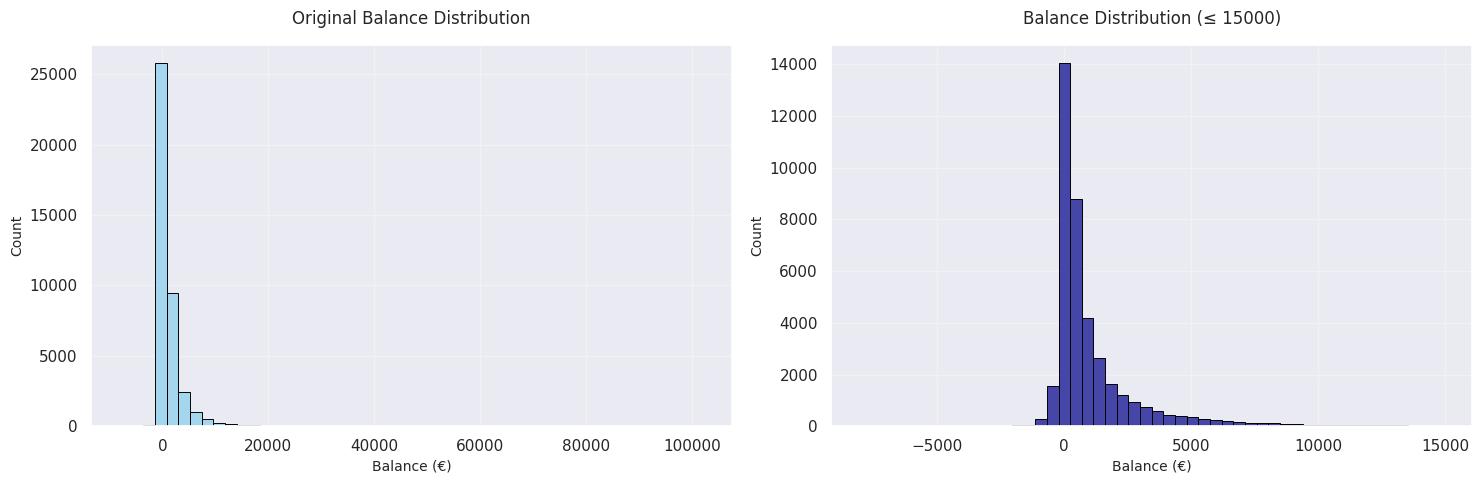


Calculating balance statistics...

Balance Statistics:
count     40000.000000
mean       1274.277550
std        2903.769716
min       -8019.000000
25%          54.000000
50%         407.000000
75%        1319.000000
max      102127.000000
Name: balance, dtype: float64
Skewness: 8.26

Creating balance categories...

Analyzing balance groups...
         balance                            y
           count      mean       std <lambda>
balance                                      
negative    6940   -171.65    314.38     5.42
very_low   20847    351.49    274.68     6.73
low         9868   2229.25   1047.30     9.04
medium      2057   7764.61   2430.43     9.87
high         288  23836.17  11434.85     7.64
=== Numeric Features Analysis ===

Analyzing age...
count    40000.000000
mean        40.544600
std          9.641776
min         19.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64
Skewness: 0.44


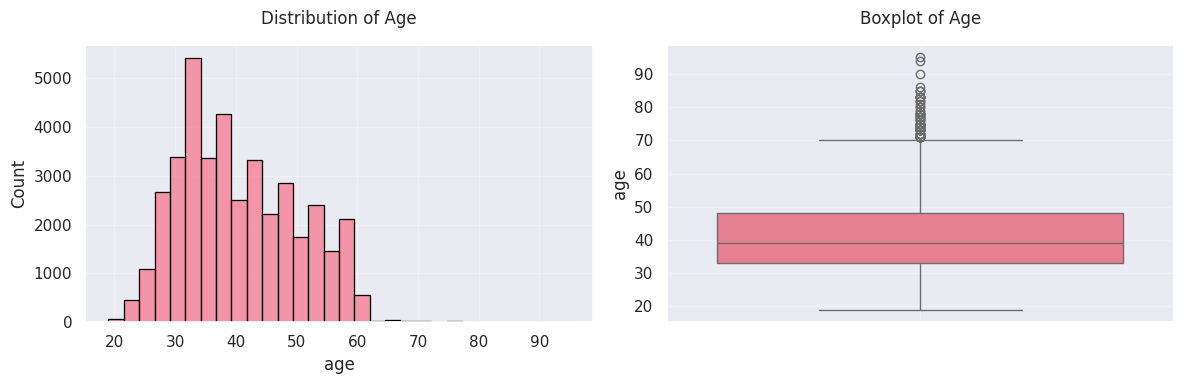


Analyzing duration...
count    40000.000000
mean       254.824300
std        259.366498
min          0.000000
25%        100.000000
50%        175.000000
75%        313.000000
max       4918.000000
Name: duration, dtype: float64
Skewness: 3.17


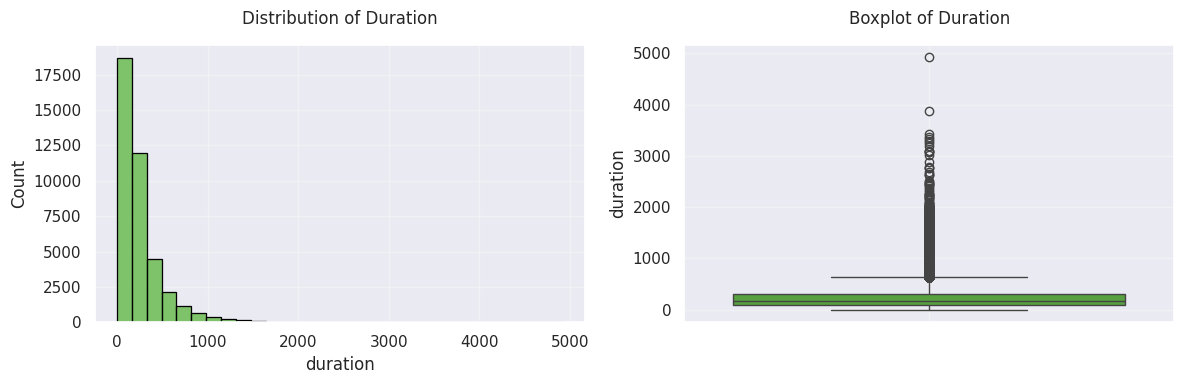


Analyzing campaign...
count    40000.000000
mean         2.882175
std          3.239051
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64
Skewness: 4.73


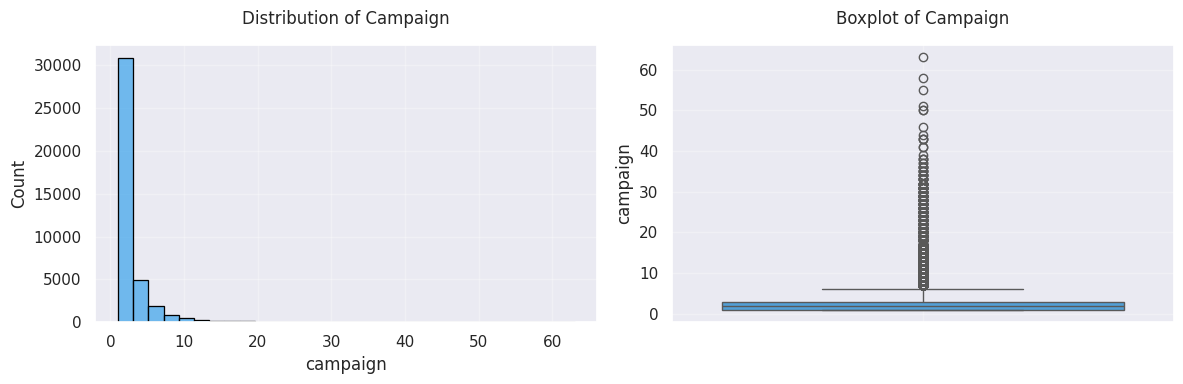


=== Categorical Features Analysis ===

Analyzing job...
job
blue-collar      0.235
management       0.204
technician       0.171
admin            0.112
services         0.098
retired          0.036
self-employed    0.035
entrepreneur     0.035
unemployed       0.028
housemaid        0.027
student          0.013
unknown          0.006
Name: proportion, dtype: float64


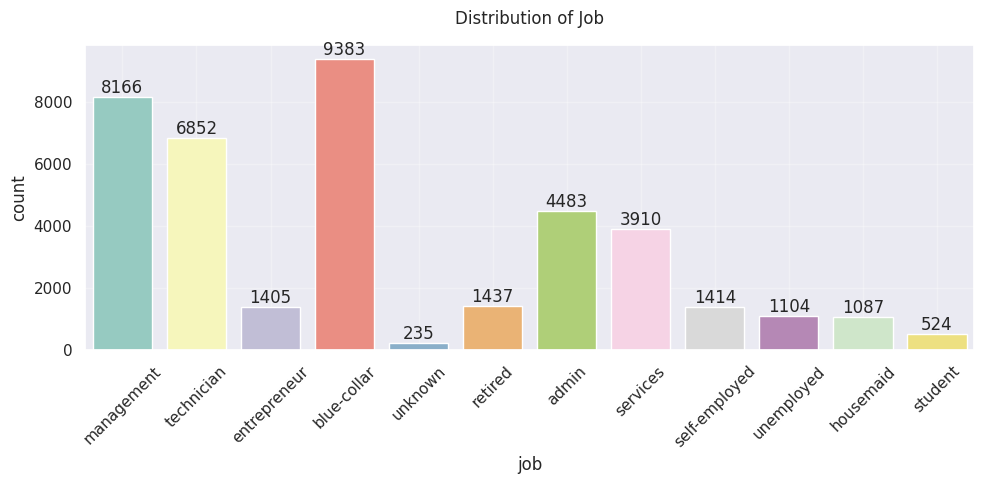


Analyzing marital...
marital
married     0.610
single      0.272
divorced    0.118
Name: proportion, dtype: float64


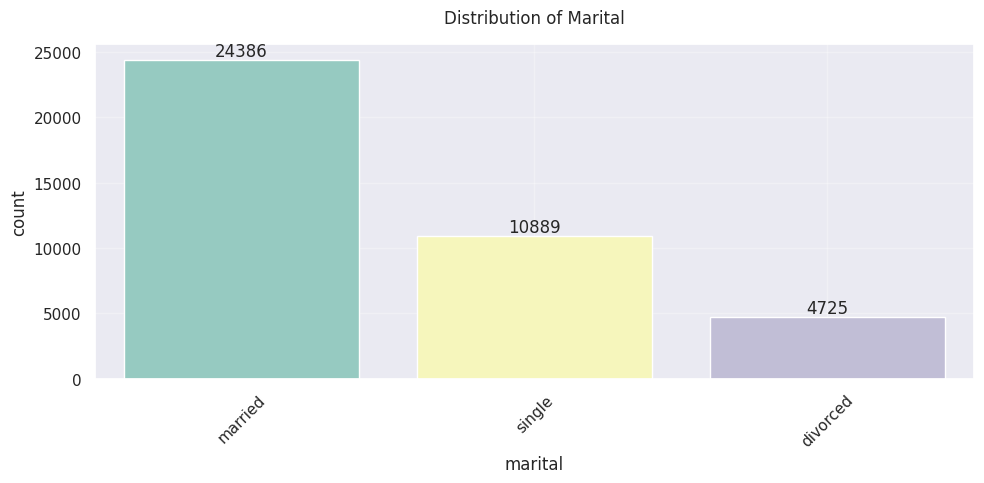


Analyzing education...
education
secondary    0.525
tertiary     0.280
primary      0.157
unknown      0.038
Name: proportion, dtype: float64


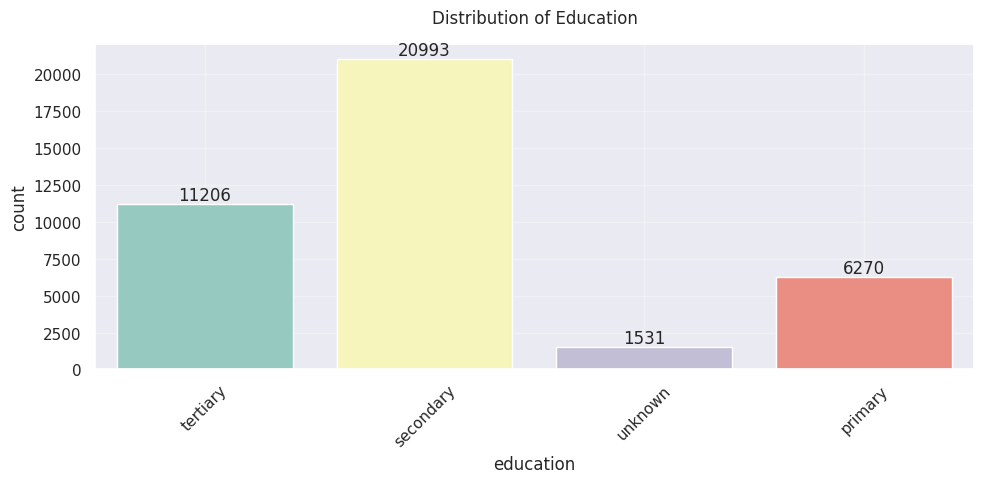


Analyzing default...
default
no     0.98
yes    0.02
Name: proportion, dtype: float64


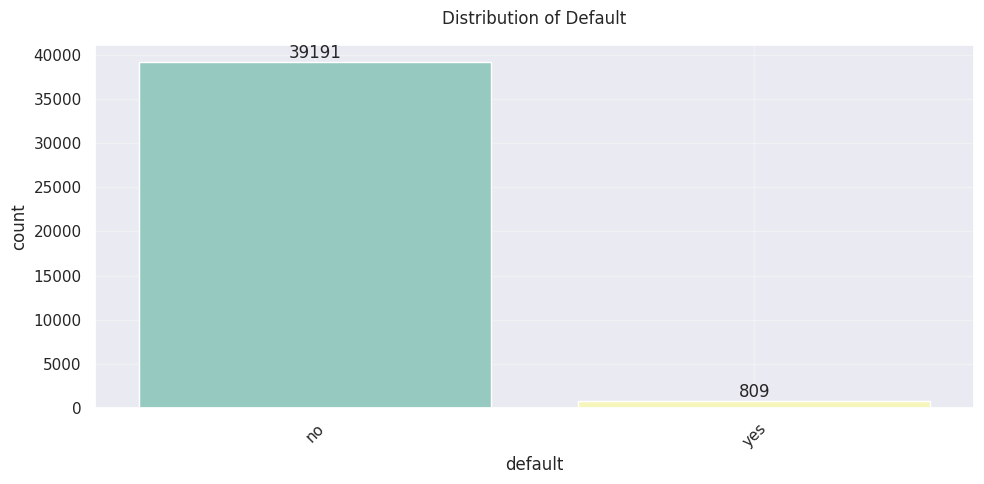


Analyzing housing...
housing
yes    0.601
no     0.399
Name: proportion, dtype: float64


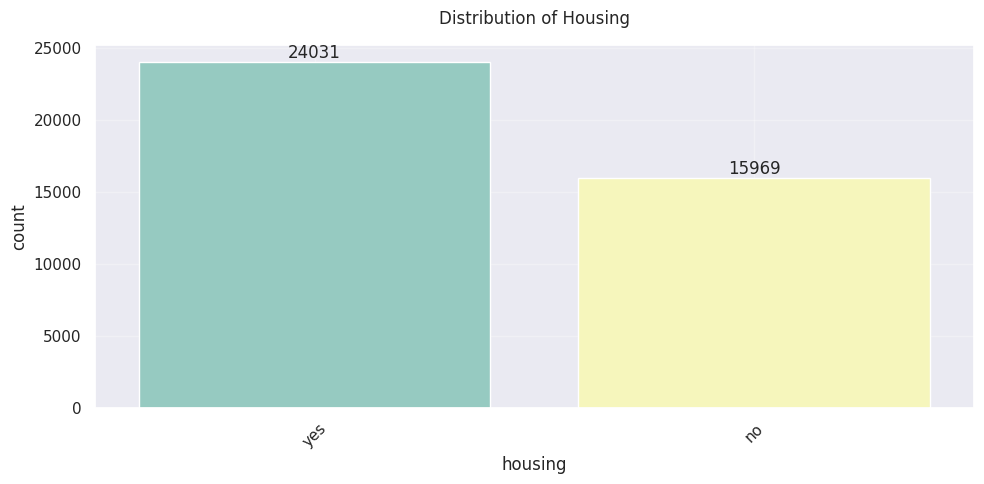


Analyzing loan...
loan
no     0.827
yes    0.173
Name: proportion, dtype: float64


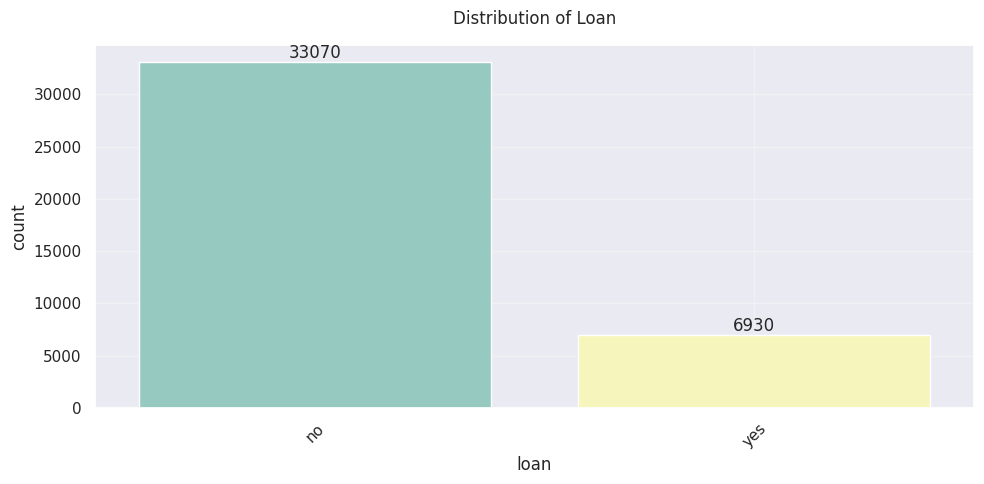


Analyzing contact...
contact
cellular     0.623
unknown      0.319
telephone    0.058
Name: proportion, dtype: float64


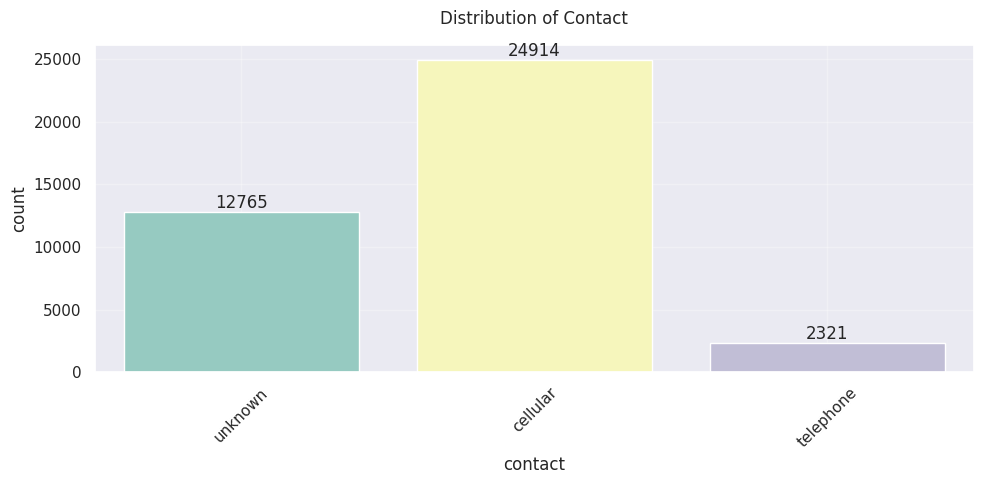


Analyzing month...
month
may    0.338
jul    0.160
aug    0.130
jun    0.118
nov    0.090
apr    0.068
feb    0.057
jan    0.029
mar    0.006
oct    0.002
dec    0.000
Name: proportion, dtype: float64


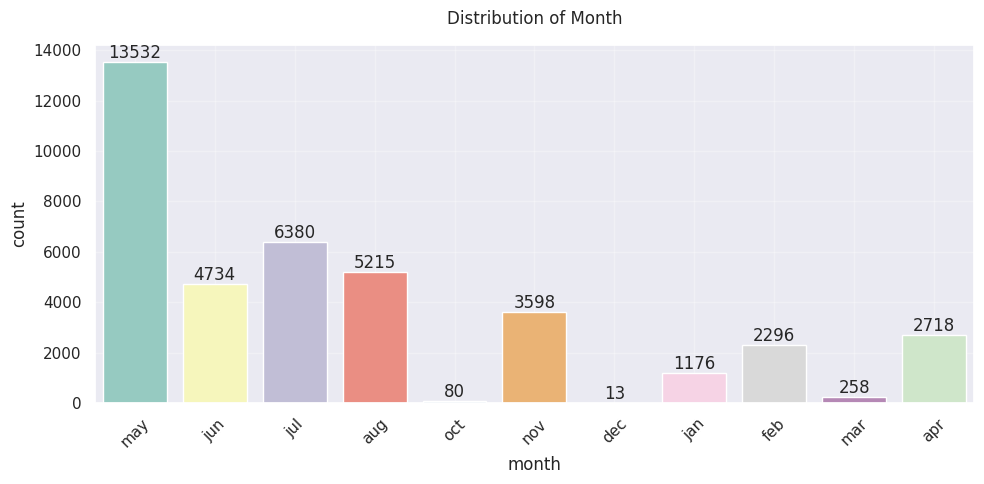

=== Bivariate Analysis with Target ===

Analyzing age vs target...


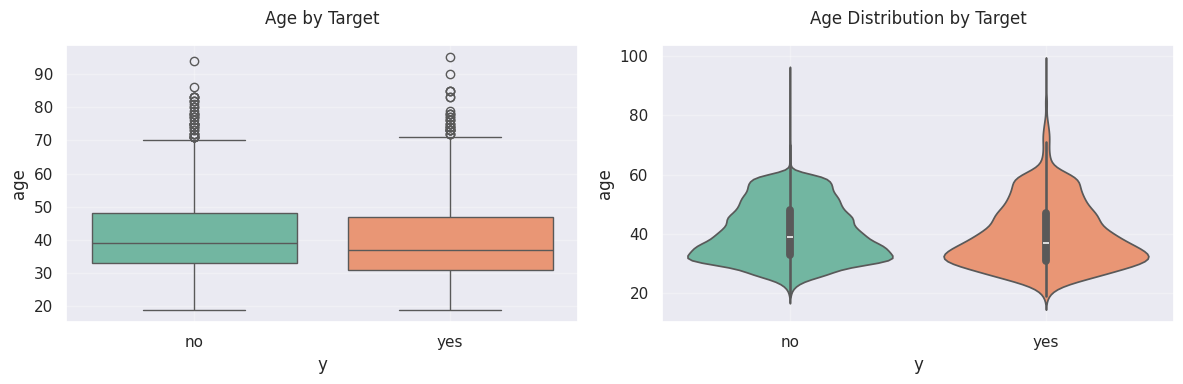


Statistics for age by target:
       count   mean    std   min   25%   50%   75%   max
y                                                       
no   37104.0  40.60   9.53  19.0  33.0  39.0  48.0  94.0
yes   2896.0  39.84  11.00  19.0  31.0  37.0  47.0  95.0

Analyzing balance vs target...


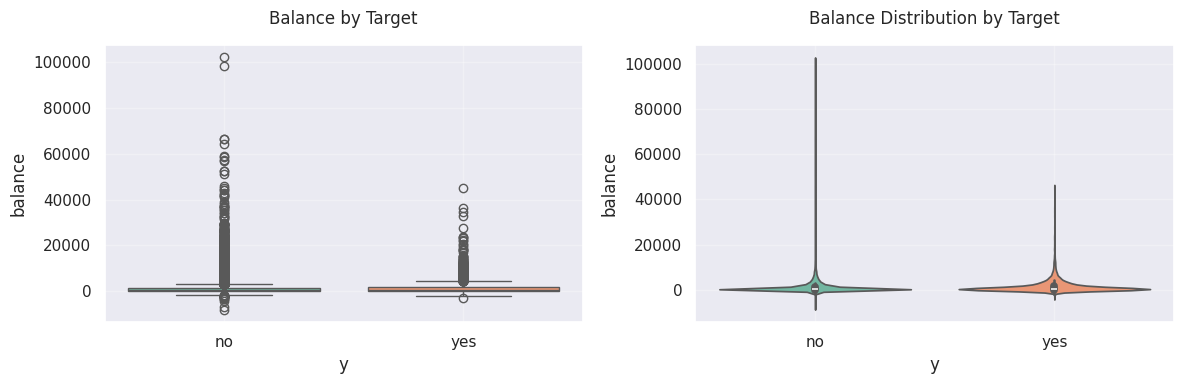


Statistics for balance by target:
       count     mean      std     min    25%    50%     75%       max
y                                                                     
no   37104.0  1249.75  2900.72 -8019.0   50.0  395.0  1286.0  102127.0
yes   2896.0  1588.50  2924.89 -3058.0  141.0  620.0  1820.5   45248.0

Analyzing duration vs target...


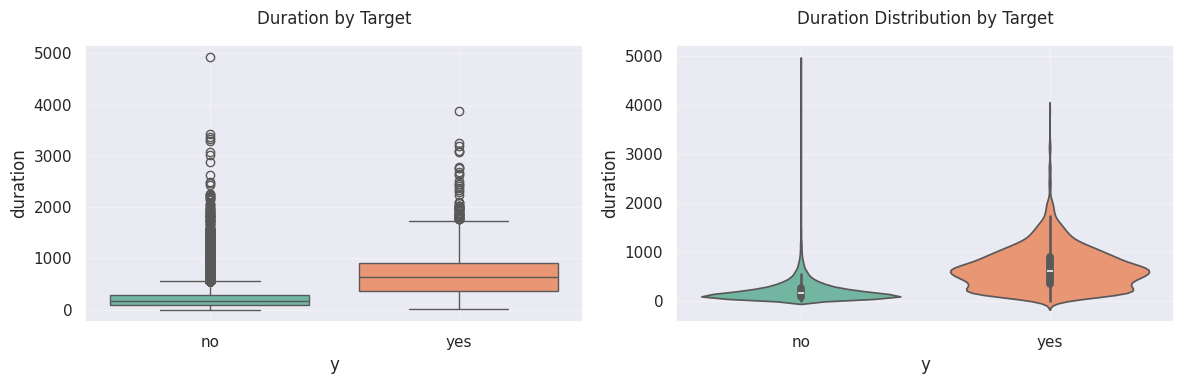


Statistics for duration by target:
       count    mean     std  min    25%    50%    75%     max
y                                                             
no   37104.0  221.41  206.36  0.0   95.0  164.0  280.0  4918.0
yes   2896.0  682.96  431.29  8.0  364.0  629.0  913.0  3881.0

Analyzing campaign vs target...


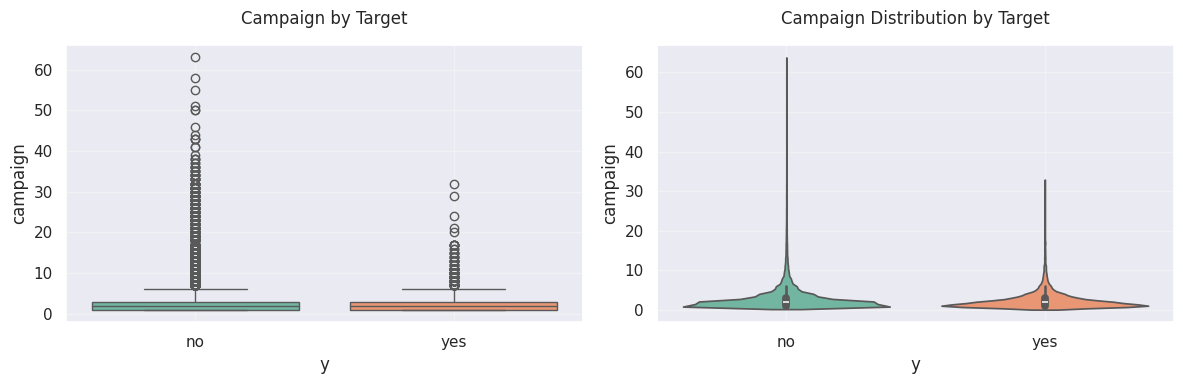


Statistics for campaign by target:
       count  mean   std  min  25%  50%  75%   max
y                                                 
no   37104.0  2.92  3.30  1.0  1.0  2.0  3.0  63.0
yes   2896.0  2.41  2.31  1.0  1.0  2.0  3.0  32.0

Analyzing job vs target...


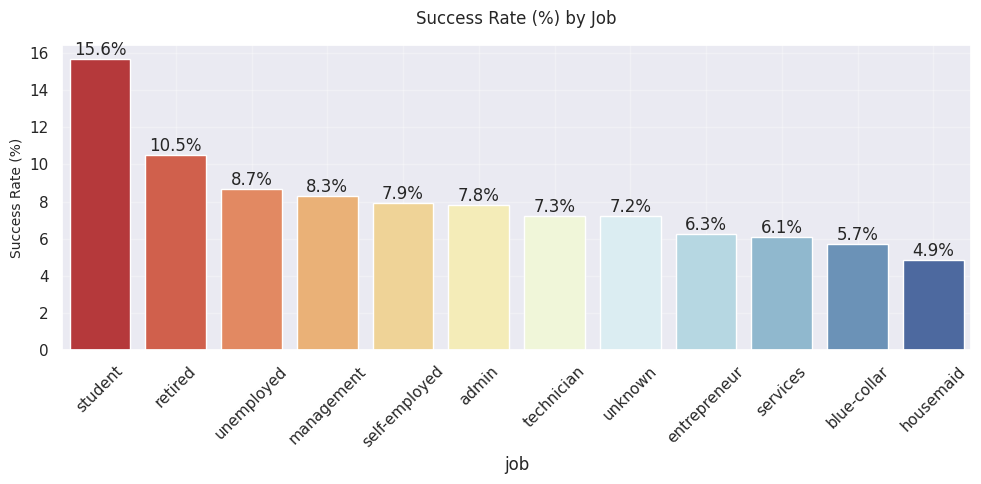


Analyzing marital vs target...


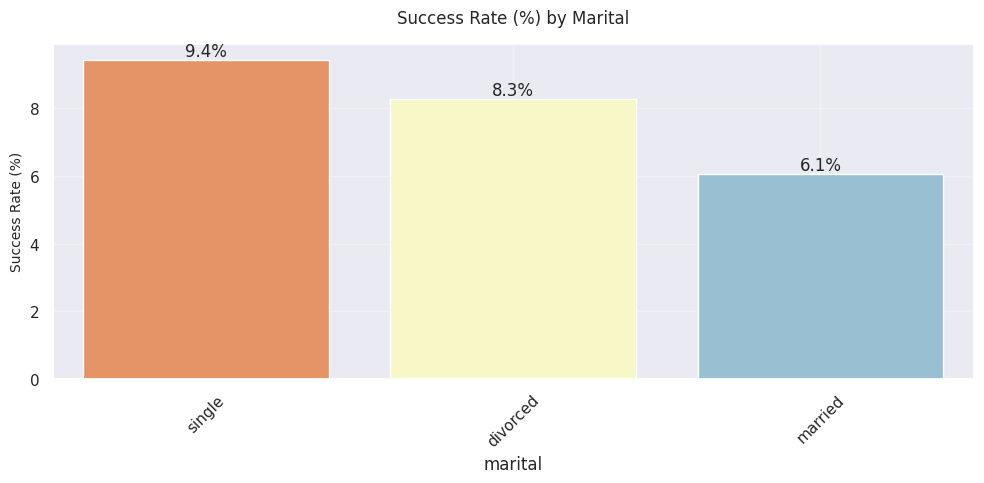


Analyzing education vs target...


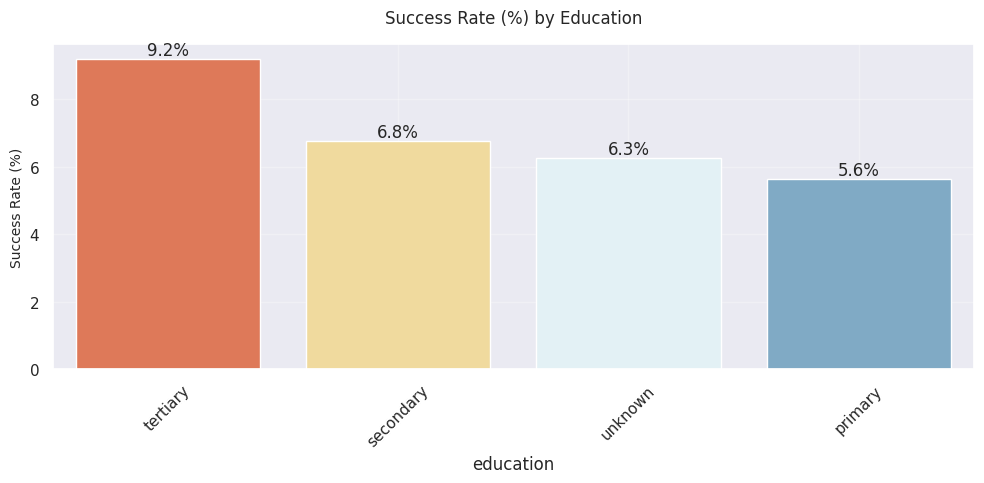


Analyzing default vs target...


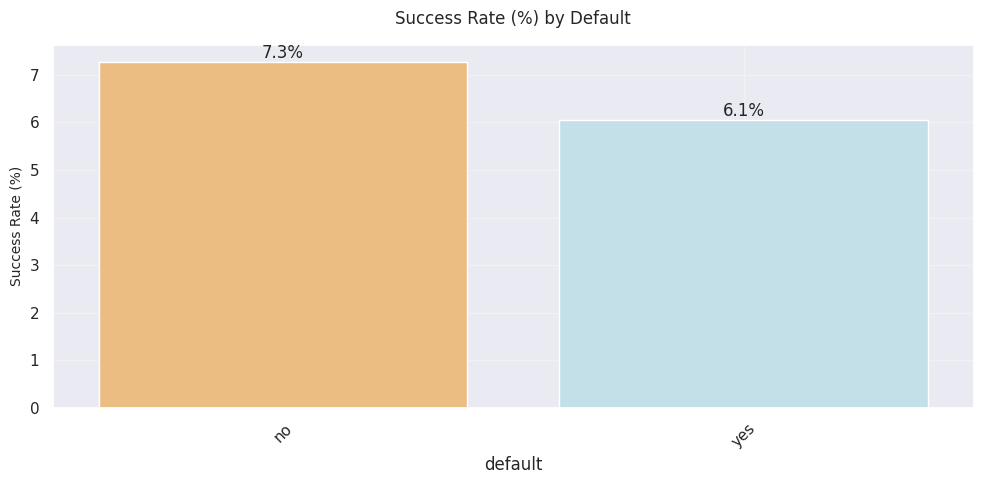


Analyzing housing vs target...


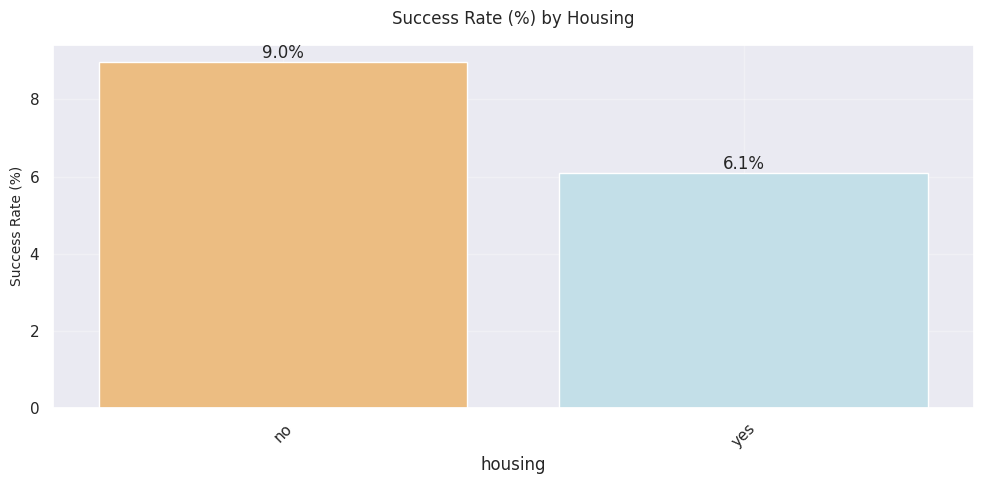


Analyzing loan vs target...


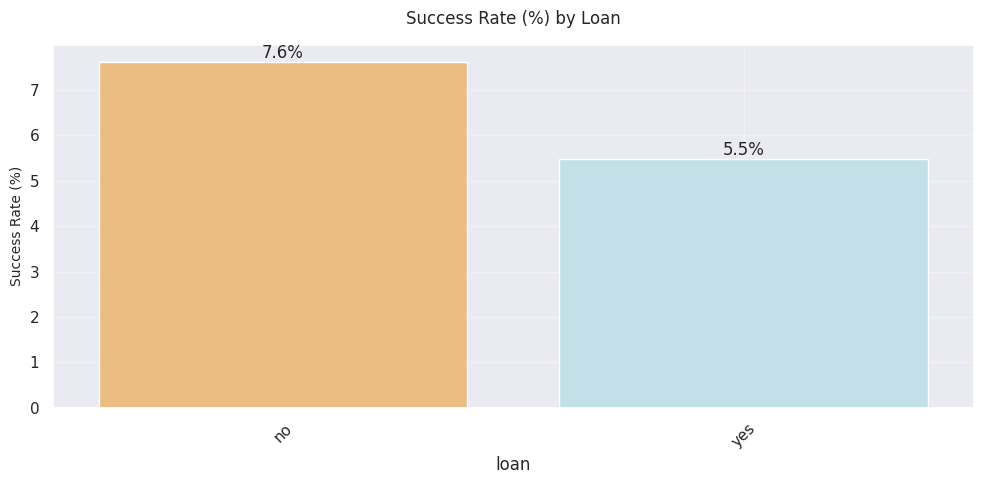


Analyzing contact vs target...


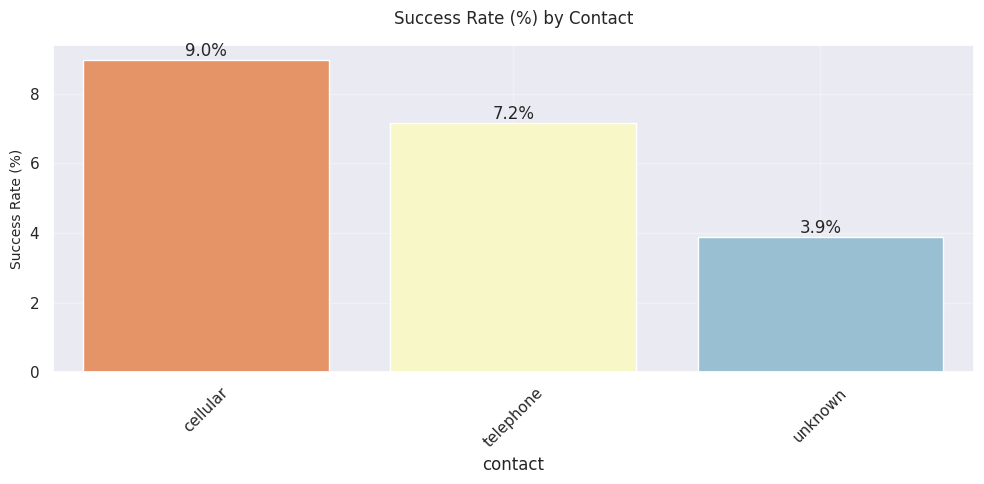


Analyzing month vs target...


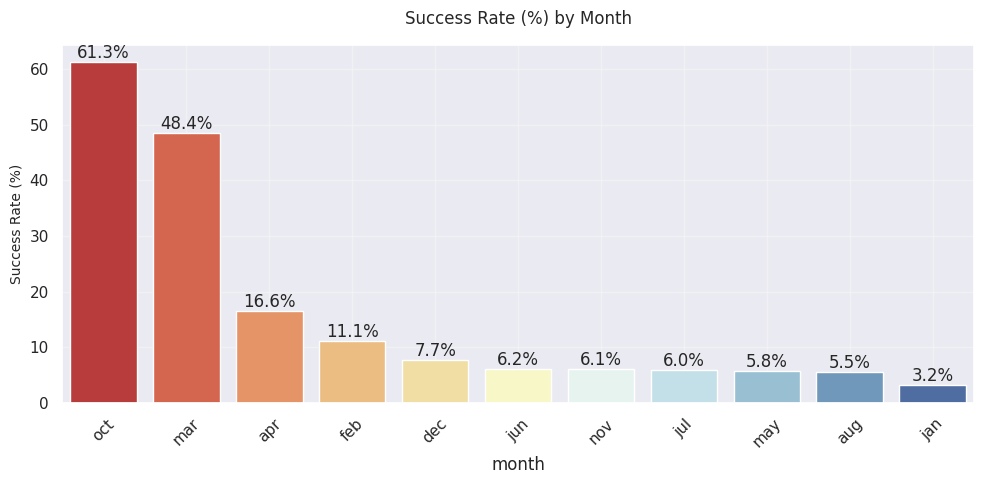

=== Feature Engineering Steps ===

1. Creating balance groups...

2. Applying log transformations...

3. Creating age groups...

4. Creating campaign intensity groups...

Preparing data for modeling...
Performing one-hot encoding...
Preparing features and target...
Total features after encoding: 59
Splitting into train and test sets...
Training samples: 32000
Testing samples: 8000

=== Model Training and Evaluation ===

Performing 5-fold cross-validation...

Detailed cross-validation scores:
Fold 1: 0.891
Fold 2: 0.887
Fold 3: 0.890
Fold 4: 0.896
Fold 5: 0.888
Mean CV Accuracy: 0.890 (+/- 0.006)

Training final model...
Making predictions...

Model Performance Metrics:
Accuracy: 0.888
ROC-AUC: 0.949

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      7421
           1       0.38      0.87      0.53       579

    accuracy                           0.89      8000
   macro avg       0.68      0.88      0.73      

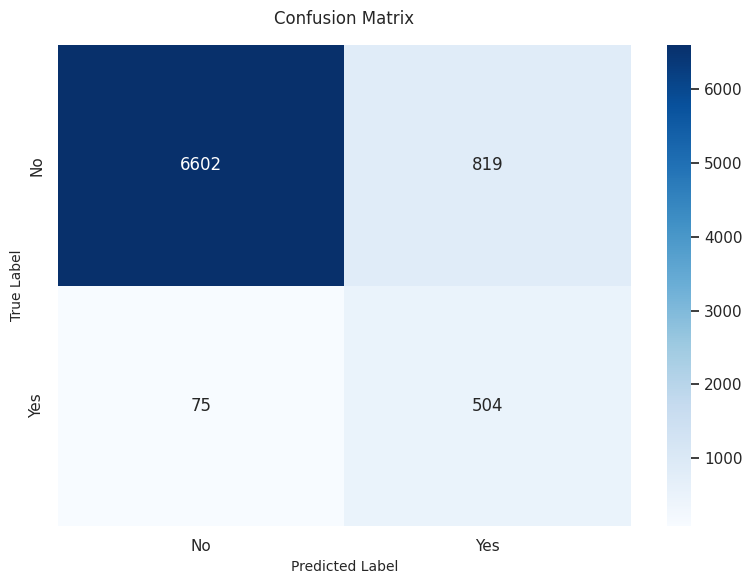


=== Final Analysis and Insights ===

Analyzing feature importance...


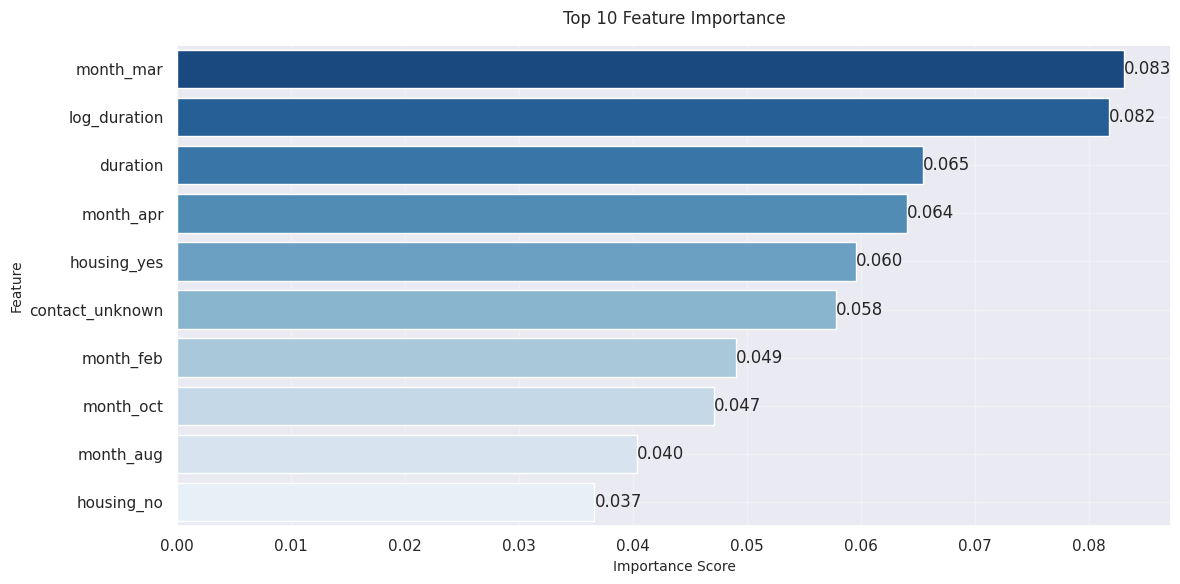


Analyzing success rates by segment...

Top education categories by success rate:
- tertiary: 9.2%
- secondary: 6.8%
- unknown: 6.3%

Top job categories by success rate:
- student: 15.6%
- retired: 10.5%
- unemployed: 8.7%

Top marital categories by success rate:
- single: 9.4%
- divorced: 8.3%
- married: 6.1%

Analyzing campaign timing...

Best performing months:
- oct: 61.3% success rate
- mar: 48.4% success rate
- apr: 16.6% success rate

Key Recommendations:
1. Target Customer Segments:
   - Focus on higher education segments
   - Target customers without existing loans
   - Prioritize cellular contact method

2. Campaign Timing:
   - Concentrate efforts in top performing months
   - Adjust contact intensity based on customer profile

3. Risk Considerations:
   - Consider balance levels in targeting strategy
   - Monitor campaign duration for optimal conversion

Analysis pipeline completed successfully!


In [9]:
# Cell 9: Final Analysis and Insights
def generate_insights(model, X_train, df):
    """
    Generate final insights and recommendations.

    Args:
        model: Trained XGBoost model
        X_train: Training features
        df: Original DataFrame

    Example:
        >>> generate_insights(model, X_train, df)
        Analyzing feature importance...
        Generating recommendations...
    """
    print("\n=== Final Analysis and Insights ===")

    # Feature importance analysis
    print("\nAnalyzing feature importance...")
    importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=importance.head(10),
                    x='importance',
                    y='feature',
                    palette='Blues_r')
    plt.title('Top 10 Feature Importance', fontsize=12, pad=15)
    plt.xlabel('Importance Score', fontsize=10)
    plt.ylabel('Feature', fontsize=10)

    # Add value labels
    for i in ax.containers:
        ax.bar_label(i, fmt='%.3f')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Success rates by segment
    print("\nAnalyzing success rates by segment...")
    for col in ['education', 'job', 'marital']:
        top = df.groupby(col)['y'].apply(
            lambda x: (x == 'yes').mean() * 100
        ).sort_values(ascending=False)

        print(f"\nTop {col} categories by success rate:")
        for category, rate in top.head(3).items():
            print(f"- {category}: {rate:.1f}%")

    # Campaign timing analysis
    print("\nAnalyzing campaign timing...")
    month_success = df.groupby('month')['y'].apply(
        lambda x: (x == 'yes').mean() * 100
    ).sort_values(ascending=False)

    print("\nBest performing months:")
    for month, rate in month_success.head(3).items():
        print(f"- {month}: {rate:.1f}% success rate")

    # Final recommendations
    print("\nKey Recommendations:")
    print("1. Target Customer Segments:")
    print("   - Focus on higher education segments")
    print("   - Target customers without existing loans")
    print("   - Prioritize cellular contact method")

    print("\n2. Campaign Timing:")
    print("   - Concentrate efforts in top performing months")
    print("   - Adjust contact intensity based on customer profile")

    print("\n3. Risk Considerations:")
    print("   - Consider balance levels in targeting strategy")
    print("   - Monitor campaign duration for optimal conversion")

# Main execution
if __name__ == "__main__":
    try:
        print("Starting bank marketing analysis pipeline...")

        # Load and check data
        df = load_and_check_data("/content/term-deposit-marketing-2020 (2).csv")

        # Perform exploratory analysis
        balance_groups = analyze_balance_distribution(df)
        perform_univariate_analysis(df)
        perform_bivariate_analysis(df)

        # Feature engineering and modeling
        df_featured = create_features(df)
        X_train, X_test, y_train, y_test = prepare_for_modeling(df_featured)
        model, y_pred, y_pred_proba = train_and_evaluate_model(X_train, X_test, y_train, y_test)

        # Generate insights
        generate_insights(model, X_train, df)

        print("\nAnalysis pipeline completed successfully!")

    except Exception as e:
        print(f"Error in analysis pipeline: {str(e)}")
        raise